# Feasibility and Impact of Converting UA's Surface Parking to Solar Power
## Final Project for ME-591

Max Schrader

### Introduction

*This notebook was compilied to satisfy the ME-591 Sustainable Energy Project.*


To satisfy the ME-591 Sustainable Energy Project, students were asked to analyze a sustainable energy project. As it is an extrememly open-ended topic, the professor gave a project centering on the University of Alabama (UA) as an example, and recommended to other students a project centered on power UA buses with hydrogen gas. 

Using UA as my centering object, my proposed project is powering UA's main campus with solar power. The land used for the solar panels will be the non-parking garage parking on campus. The potential negatives are initially glaring, i.e. Where will people park? As such, I think it is important to address the parking fears before moving onto the energy analysis and economics. Replacing all of UA's *commuter* surface parking would reduce the amount of campus parking by **6,136 spots** (per email correspondance with the Transportation Services Department), which is a substantial amount. In the time that I have been at UA (since 2015), multiple new parking lots have been constructed, showing that UA prioritizes on-campus parking. I think that this is a critical mistake. There is no data published by UA on the distance that the average student who parks on-campus commutes, but I would contend from personal experience that it is not far. While it is not in the scope of this project, I think interesting research could be done on the environmental benefit of replacing commuter trips with bus routes - buses that are used because an alternative is not available. In addition to environmental benefits, environments centered on public transit and foot-traffic are generally more enjoyable. Anyone who travels to Europe notices that the best places also seem to be the hardest to get to via car. I would contend that there is correlation, and UA should experiment with designing a mostly car-free environement. It would be extremely hard to get faculty and staff onboard with a transition to a "car-free" campus if their parking was elimated, so parking garages would remain open, serving both staff as well as ADA parking and UA students who commutes a over a specific distance.

With the reduction in parking addressed (whether it was a sufficient argument or not being beyond the scope of this project), the remaining pages of this report cover the economics and environmental benefit of converting UA's surface parking to solar panel arrays. The first iteration of this report was created with the naive assumption that solar could power the entire campus, and thus calculations were also done for a hydro battery. After receiving UA's energy consumption data for an entire year, it was clear the converting the parking lots to solar arrays could not supply all of UA's power, instead it could only ever make up about 13% of the power requirements. This means that energy storage was not necessary, and therefore the calculations are not included in this iteration of the report.

#### Python Imports

In [1]:
import pint
import math
import numpy as np
import pandas as pd
from pytz import timezone
import pint_pandas
import atlite
import logging
import geopandas as gpd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "ggplot2"
pio.renderers.default = "notebook+pdf"
logging.basicConfig(level=logging.ERROR)
ureg = pint.UnitRegistry(autoconvert_offset_to_baseunit = True)
pint_pandas.PintType.ureg = ureg

## Calculations

### Assessing UA's Current Electricity Demand

This data comes from Will Stephens, an Energy Engineer with UA's Facilities and Grounds Department. The total UA Main Campus energy consumption is the sum of four substations - East, West, North and South. The data encapsulates the entire year of 2019, which was chosen as COVID did not affect the consumption.

The data is recorded every 15 minutes in power (kW) and listed at the end of the time period. Per Will's instruction, to get the power demand in kWh, one should multiple the power demand by 0.25. In a more verbose form:

$$E[\textrm{kWh}] = P[\textrm{kW}] \cdot 15 \textrm{min} \cdot \frac{1\textrm{h}}{60\textrm{min}}$$

#### Loading the Data

In [2]:
df_dict = {}
for direction in ["East", "West", "North", "South"]:
    df_dict[direction] = pd.read_csv(f"./UA Energy/{direction} Sub kW Demand Info - 2019-01-01 - 2019-12-31.csv", 
                                     skiprows=16,
                                     parse_dates=[['Date', 'Time']])

In [3]:
for name, df in df_dict.items():
    if 'TOTAL - KW-TOT' not in df.columns:
        df['TOTAL - KW-TOT'] = df[[col for col in df.columns if col not in ['Date_Time']]].sum(axis=1)
    for col in df.columns:
        if col not in 'Date_Time':
            # Shift the data so that power consumption is associated with the start time
            df[col] = df[col].shift(-1)
            # drop the last period
            df.drop(df.iloc[-1].name, inplace=True)

##### Creating the Total Dataframe

In [4]:
total_df = df_dict['East'][['Date_Time', 'TOTAL - KW-TOT']].copy()
for name, df in df_dict.items():
    total_df[f'{name}-TOTAL'] = df['TOTAL - KW-TOT'].astype("pint[kW]")
    if name not in 'East':
        total_df['TOTAL - KW-TOT'] += df['TOTAL - KW-TOT']
total_df['TOTAL - KW-TOT'] = total_df['TOTAL - KW-TOT'].astype("pint[kW]")

##### Set the Index to a Timezone-aware Datetime

In [5]:
tz = timezone('US/Central', )
total_df['Date_Time'] = total_df['Date_Time'].apply(tz.localize, is_dst=False)
total_df.set_index('Date_Time', inplace=True, drop=False)

#### Calculating the Energy Consumption

In [6]:
for col in total_df.columns:
    if col not in 'Date_Time':
        total_df[col.split('-')[0] + " Energy"] = total_df[col] * 0.25 * ureg.hour  # in kWh

In [7]:
total_df['TOTAL - KW-TOT'].mean()

27877.04315930694 <Unit('kilowatt')>

In [8]:
total_df['TOTAL  Energy'].sum().to('GWh')

244.15411325 <Unit('gigawatt_hour')>

#### Plotting the Weekly Power Average for 2019

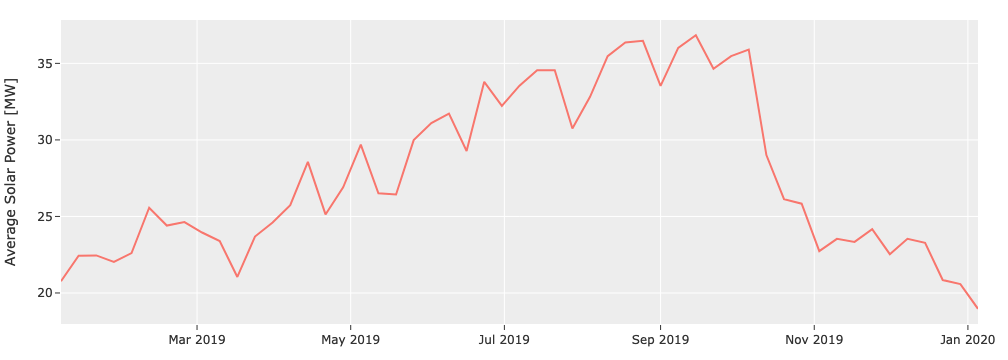

In [9]:
x = total_df.resample('1W').mean().index
# this is nasty chaining
y = total_df['TOTAL - KW-TOT'].pint.to('MW').resample('1W').mean().pint.magnitude

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y.values
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=800,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Average Solar Power [MW]",
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

fig.show(renderer='jupyterlab')

In summary, UA used 244 GWh of electricity throughout the year. Assuming that 2019 is representative of the average year at UA, this electricity usage peaks in late September / early October at 36.8 MW. To put that in context, per https://www.eia.gov/energyexplained/use-of-energy/electricity-use-in-homes.php, the average house consumes 11,000 kWh per year. UA's energy consumption is the equivalent of **22,181 homes.**

### Solar Potential Calculation 

#### Simplistic, from the book

##### Average Daily Solar Radiation on a Horizontal Surface in Selected Cities in the United States

Given in $\frac{MJ}{m^2 \cdot day}$

In [175]:
G_solar = list(map(lambda x: x * ureg.MJ / (ureg.m ** 2 * ureg.day), [9.20, 11.92, 13.67, 19.65, 21.58, 22.37, 21.24, 20.21, 17.15, 14.42, 10.22, 8.40]))
G_solar = {i + 1: {'G': g, 'D': (30 if i % 2 else 31) * ureg.day} for i, g in enumerate(G_solar)}
# Manually Correcting Feb. Days
G_solar[2]['D'] = 28 * ureg.day

##### Calculating the Surface Area Available   

Using Google Maps, I calculated the surface area of all the considered parking lots

In [12]:
parking_lots = pd.read_csv("ParkingLotArea.csv")
parking_lots.latex()

,Lot,Area (ft),Parking Group,Parking Spots,Lat,Lon
0,NE of NE Commuter,234753.94,NE Commuter,NaN,33.214818,-87.532654
1,Cent. of NE Commuter,206558.77,NE Commuter,NaN,33.214818,-87.532654
2,S of NE Commuter,112735.93,NE Commuter,NaN,33.213234,-87.533540
3,Frat of NE Commuter,283463.92,NE Commuter,NaN,33.209185,-87.533937
4,Cyber Hall Parking,97977.49,Faculty,NaN,33.220687,-87.537042


In [13]:
parking_lots['Area (ft)'] = parking_lots['Area (ft)'].astype("pint[ft^2]")

##### Calculating the Theoretical Energy per Day

This calculations relies on the solar radiation values from the textbook, as well as the 19% efficiency of the chosen solar panels.

In [176]:
N_pv = 0.19 # the efficiency of SunPower P-series 

In [177]:
for month, inner_dict in G_solar.items():
    parking_lots[f'P_{month}'] = (parking_lots['Area (ft)'] * N_pv * inner_dict['G']).pint.to("MJ / day")

##### Average Daily per Lot and Total

In [16]:
parking_lots['P_avg'] = 0 
parking_lots['P_avg'] = parking_lots['P_avg'].astype('pint[MJ / day]') 

for month, inner_dict in G_solar.items():
    parking_lots['P_avg'] += parking_lots[f'P_{month}'] * inner_dict['D'] / (365 * ureg.day)

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pint_pandas/pint_array.py:194: RuntimeWarning:

pint-pandas does not support magnitudes of <class 'numpy.int64'>. Converting magnitudes to float.



In [17]:
parking_lots['P_total'] = (parking_lots['P_avg'] * 365 * ureg.day)

In [193]:
parking_lots.to_latex()

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



'\\begin{tabular}{llllrrrlllllllllllllllrrr}\n\\toprule\n{} &                   Lot &  Area (ft) &       Parking Group &  Parking Spots &        Lat &        Lon &                 P\\_1 &                 P\\_2 &                 P\\_3 &                 P\\_4 &                 P\\_5 &                 P\\_6 &                 P\\_7 &                 P\\_8 &                 P\\_9 &                P\\_10 &                P\\_11 &                P\\_12 &               P\\_avg &             P\\_total & \\# of Panels &  PV Capacity &   lon &    lat \\\\\n\\midrule\n0 &     NE of NE Commuter &  234753.94 &         NE Commuter &            NaN &  33.214818 & -87.532654 &   38122.75197710484 &   49393.82647468366 &  56645.436905111215 &   81425.22569022936 &   89422.71605064374 &    92696.3001878082 &   88013.83173844639 &   83745.74102796619 &      71065.78221819 &   59753.26994672302 &  42349.404913696904 &   34807.73006605225 &   65507.10352535206 &    23910092.7867535 &       10038 &     3.207

#### Calculating the installed capacity, using the available area and Sun Power's Datasheet

Using [Sun Power's Datasheet](https://us.sunpower.com/sites/default/files/media-library/data-sheets/ds-sunpower-p17-355-1500v-commercial-solar-panels.pdf) the installed capacity can be calculated. It is not the actually capacity given the average solar radiation in Tuscaloosa, Alabama, but simply the upper limit of what is possible given the area available for solar generation.

The total solar capacity is calculated as 

$$\textrm{Capacity}_{\textrm{solar}} = N_{panels} \cdot \dot{W}_{panel} * N_{\textrm{ac/dc}}$$

where $N_{panels}$ is the number of panels that can fit on the parking lots. The formula that I used is

$$N_{panels} = \textrm{floor}\left(\frac{A_{\textrm{parking lot}}}{A_{\textrm{solar panel}}} \cdot N_{\textrm{area}}\right)$$

where $N_{\textrm{area}}$ is a scaling factor $< 1$ to account for the fact that not 100% of the parking lot surface area can likely be utilized by solar panels, as there will be transformer hardware etc.

In [181]:
P_pv = 355 * ureg.watt
A_pv = 81.4 * 39.3 * ureg.inch ** 2
N_ac_dc = .9
N_area = 0.95  # estimating that not all surface area will be covered by panels due to geometry constraints etc.

##### Determining the number of SunPower P17 Panels that can fit on each surface

Used https://pvwatts.nrel.gov/pvwatts.php as a check and it confirms the estimate

In [182]:
parking_lots['# of Panels'] = (parking_lots['Area (ft)'] / A_pv * N_area).pint.to('dimensionless')
parking_lots['# of Panels'] = np.floor(parking_lots['# of Panels'])
parking_lots['# of Panels']

0    10038
1     8833
2     4820
3    12121
4     4189
5     4910
6     5730
7     7924
8     9089
9     5600
Name: # of Panels, dtype: object

In [183]:
parking_lots['PV Capacity'] = parking_lots['# of Panels'] * P_pv * N_ac_dc
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].astype('pint[W]')
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].pint.to('MW')
# parking_lots['PV Capacity']

In [184]:
parking_lots['PV Capacity'].sum()

23.404653 <Unit('megawatt')>

Using the constants above, the total installed capacity is 23.4 MW

#### Plotting the Installed Capacity vs. Monthly Power Consumption

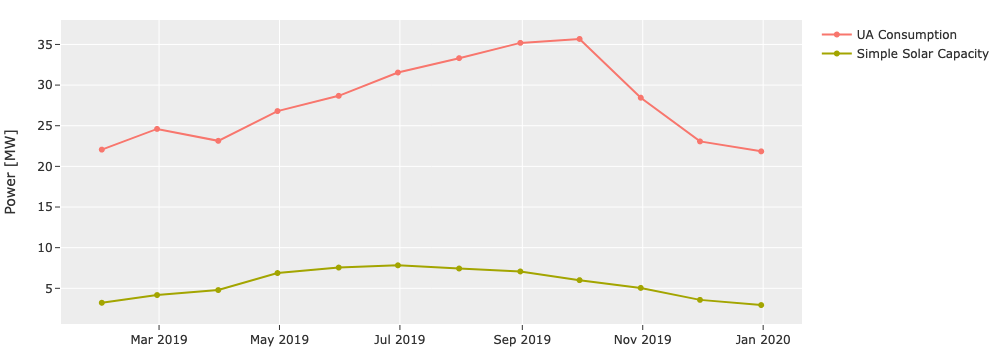

In [22]:
total_monthly_capacity = [parking_lots[f"P_{m + 1}"].sum().to('MW').magnitude for m in range(12)]

x = total_df.resample('1M').mean().index
# this is nasty chaining
y = total_df['TOTAL - KW-TOT'].pint.to('MW').resample('1M').mean().pint.magnitude

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y.values,
        name="UA Consumption"
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=total_monthly_capacity,
        name="Simple Solar Capacity"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Power [MW]",
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

fig.show(renderer='jupyterlab')

### Complicated Capacity Estimate

#### Using the ERA5 Dataset

In [186]:
bl = 32.988320041698074, -87.79145924201974
tr = 33.473235950702524, -87.32768306322347

cutout = atlite.Cutout(path="Alabama.nc",
                       module="era5",
                       x=slice(bl[1], tr[1]),
                       y=slice(bl[0], tr[0]),
                       time="2015"  # "2018-12")
                       )

/Users/max/Development/homework/venv/lib/python3.8/site-packages/atlite/cutout.py:179: UserWarning:

Arguments module, x, y, time are ignored, since cutout is already built.



#### Downloading ERA5 Data for the specified cutout

In [24]:
cutout.prepare()

<Cutout "Alabama">
 x = -87.75 ⟷ -87.50, dx = 0.25
 y = 33.00 ⟷ 33.25, dy = 0.25
 time = 2015-01-01 ⟷ 2015-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

#### Finding the Cutout Cell Nearest to the UA Parking Lots

In [187]:
cells = gpd.GeoDataFrame({'geometry': cutout.grid_cells,
                          'lon': cutout.grid_coordinates()[:,0],
                          'lat': cutout.grid_coordinates()[:,1]})

In [188]:
nearest_cell = cutout.data.sel({'x': parking_lots.Lon.values,
                                'y': parking_lots.Lat.values},
                               'nearest').coords

In [189]:
# Map capacities to closest cell coordinate
parking_lots['lon'] = nearest_cell.get('lon').values
parking_lots['lat'] = nearest_cell.get('lat').values

In [190]:
parking_lots['PV Capacity'] = parking_lots['PV Capacity'].pint.magnitude

In [29]:
new_data = parking_lots.merge(cells, how='inner')

# Sum capacities for each grid cell (lat, lon)
# then: restore lat lon as coumns
# then: rename and reindex to match cutout coordinates
new_data = new_data.groupby(['lon','lat']).sum()

layout = new_data.reset_index().rename(columns={'lat':'y','lon':'x'})\
                    .set_index(['y','x'])['PV Capacity']\
                    .to_xarray().reindex_like(cutout.data)

layout = layout.fillna(.0).rename('Installed Capacity [MW]')

In [30]:
pv = cutout.pv(panel="CSi", orientation='latitude_optimal', layout=layout)

#### Put the data into a DataFrame and fixing the timezone

In [31]:
pv_df = pd.DataFrame(pv.squeeze().to_series())

In [32]:
tz = timezone('GMT', )
pv_df['Date_Time'] = pv_df.index.values
pv_df['Date_Time'] = pv_df['Date_Time'].apply(tz.localize, is_dst=False)
pv_df['Date_Time'] = pv_df['Date_Time'].dt.tz_convert(timezone('US/Central'))

pv_df.set_index('Date_Time', inplace=True)

#### Plotting In-depth Solar vs. UA Power Consumption vs. Simple Solar Calculation

##### Average Weekly Power

/Users/max/Development/homework/venv/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:741: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



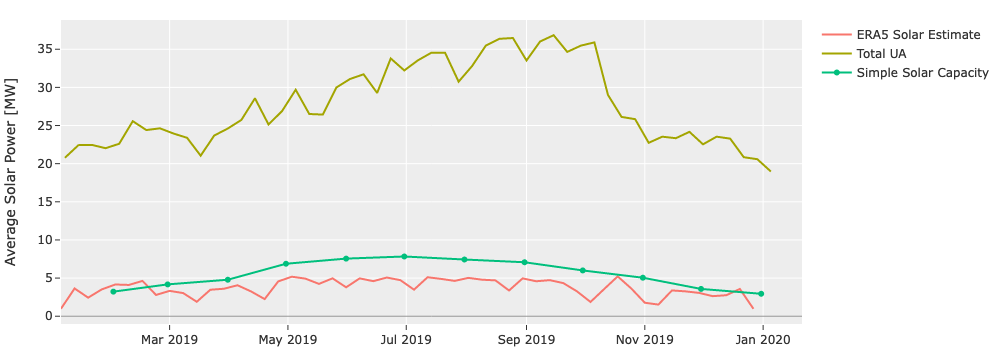

In [33]:
fig = go.Figure()

weekly = pv_df[0].resample('1W').mean()

fig.add_trace(
    go.Scatter(
        x=weekly.index + pd.offsets.DateOffset(year=2019), 
        y=weekly.iloc[:-1].values,
        name="ERA5 Solar Estimate"
    )
)

x = total_df.resample('1W').mean().index
y = total_df['TOTAL - KW-TOT'].pint.to('MW').resample('1W').mean().pint.magnitude

fig.add_trace(
    go.Scatter(
        x=x,
        y=y.values,
        name="Total UA"
    )
)


total_monthly_capacity = [parking_lots[f"P_{m + 1}"].sum().to('MW').magnitude for m in range(12)]
x = total_df.resample('1M').mean().index

fig.add_trace(
    go.Scatter(
        x=x,
        y=total_monthly_capacity,
        name="Simple Solar Capacity"
    )
)


fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Average Solar Power [MW]",
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

fig.show(renderer="jupyterlab")

### Daily in May

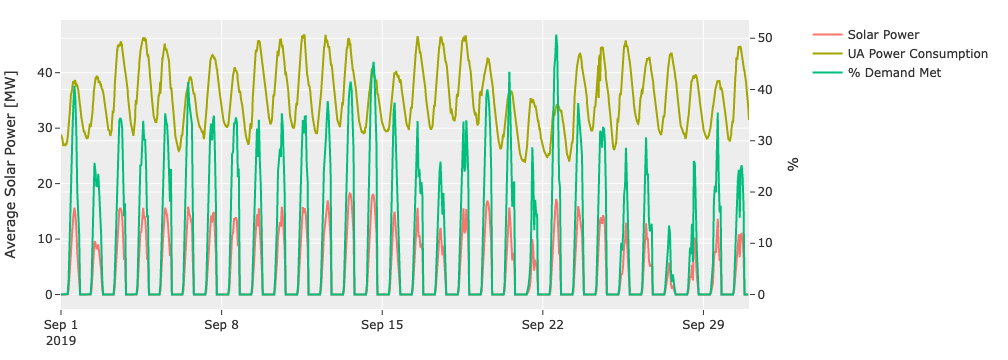

In [34]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=pv_df[0].loc[pv_df.index.month == 9].index + pd.offsets.DateOffset(year=2019), 
        y=pv_df[0].loc[pv_df.index.month == 9].values,
        name="Solar Power"
    )
)

fig.add_trace(
    go.Scatter(
        x=total_df.loc[total_df.index.month == 9].index,
        y=total_df.loc[total_df.index.month == 9, 'TOTAL - KW-TOT'].pint.to('MW').pint.magnitude,
        name="UA Power Consumption"
    )
)


fig.add_trace(
 go.Scatter(
        x=pv_df[0].loc[pv_df.index.month == 9].index + pd.offsets.DateOffset(year=2019),
        y=pv_df[0].loc[pv_df.index.month == 9].values / 
         total_df.loc[total_df.index.month == 9, 'TOTAL - KW-TOT'].resample('1H').mean().pint.to('MW').pint.magnitude * 100,
        name="% Demand Met",
    ),
    secondary_y=True
)


fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Average Solar Power [MW]",
    yaxis2_title="%"
    # xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

fig.show(renderer="jupyterlab")

## Determining the actual area required for solar panels to power UA's campus

UA's average power consumption peaks in September at a value of 35675 kW. In order for solar to **completely** supply UA's campus with power, the monthy average solar power would have to be greater than this value. Assuming that both solar radiation and solar panel efficiency are fixed, this calls for more area devoted to solar panels. The calculations below determine roughly the area required, though the simple calculation over-estimates the solar power available, and a correction factor will be applied, which is simply $\frac{\textrm{era5 estimate}_{September}}{\textrm{simple estimate}_{September}}$



In [35]:
total_required_power = total_df.loc[total_df.index.month == 9, 'TOTAL - KW-TOT'].pint.to('MW').mean()
total_required_power

35.67570416666667 <Unit('megawatt')>

$$A = \frac{P_{desired}}{N_{pv} G}$$  

#### Correction Factor

In [36]:
corr_factor = pv_df[0].loc[pv_df.index.month == 9].mean() / parking_lots[f"P_9"].sum().to('MW').magnitude
corr_factor

0.677499185567263

### The Total Area Required

In [37]:
A = total_required_power / (N_pv * G_solar[9]['G'] * corr_factor)
A.to('m^2')

1396239.0932734653 <Unit('meter ** 2')>

For scale, this area is around the size of UA's main campus.

![area](area.png)

### Hydro Battery Calculations

I was going to do hydro-battery calculations for my proposal, as some storage device is necessary to capture the full potential of solar power if it is to be the main power source. Given UA's power demand though, storage is not required. Even during peak-sun periods, the solar panels do not provide excess power that needs to be stored. 

If there was an excess energy provided by the panels, I think an interesting storage solution would be a hydro-battery. UA's main campus has two geological advantages for a hydro-battery: a river 500m from campus and ~100ft of elevation change between campus and the river. The river provides ample water for a battery to operate with relatively little impact down / upstream, with a flow rate of 2000 cubic feet per second. The natural change in elevation means that water could be pumped to a resevoir on UA's campus and stored with little investment in infrastructure.

There is of course the glaring question as to why both the solar and hydro storage have to be on UA's campus and not instead on land else where. The answer is simply that for the class we were asked to propose a project related to the campus.

Flow reference: https://water.weather.gov/ahps2/hydrograph.php?wfo=bmx&gage=toda1

## Economics of the Proposal

implementation cost, simple payback, net present value, and ROI

For comparision https://buildingbama.ua.edu/projects/new-tutwiler-residence-hall/ costs $144,900,659.00

The assumed interest rate is 6%

In [99]:
i = 0.06

### Solar Implementation Cost

Per https://www.seia.org/research-resources/solar-market-insight-report-2021-q3, utility-level solar projects have an average cost of \$0.90 per Watt of DC power.

In [85]:
parking_lots['PV Capacity'].sum()

23.404653

In [83]:
C_solar = 0.9 / ureg.W
cost_solar = parking_lots['PV Capacity'].sum() * ureg.MW * C_solar
cost_solar = cost_solar.to('dimensionless')
cost_solar.magnitude

21064187.700000003

The cost of turn-key installation is $21,064,187

### Cost of Electricity

If UA had the capability to generate solar energy, they would save tremendously on the cost of electricity.

In [86]:
c_p_kwh = 13.53 / 100 / ureg.kWh   # 13.53 cents per kWh per https://www.chooseenergy.com/electricity-rates-by-state/

### Determining UA's Yearly Power Bill

Because UA consumes so much electricity, it is likely that they received discounted rates from the local utility company or buy energy futures. Without having the information on UAs effective cost of electricity, below is my best estimate.

In [87]:
yearly_elec = total_df['TOTAL  Energy'].sum()

In [88]:
yearly_elec.to('kWh') * c_p_kwh

33034051.522725 <Unit('dimensionless')>

Using the assumptions alluded to above, UA pays \$33,034,051 per year in electricity

### The Total Energy that Solar Could Provide UA

The total energy that solar energy will supply in a year is calculated as the numerical integral of the era5 estimate.

In [89]:
yearly_solar_electricity = (np.trapz(pv_df[0], dx=3600) * ureg.MW * ureg.s).to('kWh')

In [90]:
yearly_solar_electricity_savings = yearly_solar_electricity.to('kWh') * c_p_kwh

Converting the parking lots to solar installations could save UA \$4,407,000.0 per year on electricity

### Present Value of Annual Savings

SunPower has a 25 year warranty, so I am using that as the lifespan of the panels. 

There is no good information online about the salvage value of solar panels, so I am assuming that it is 0.

$$P = U \left[\frac{1 - (1 + i)^{-n}}{i}\right]$$

In [101]:
n = 25

pv_as = yearly_solar_electricity_savings.magnitude * (1 - (1 + i) **(-1 * n)) / i
pv_as

56339815.92712577

### Present Value of the Maintence Costs

I am assuming that cleaning happens every year and thus wrapped into the maintence cost

In [50]:
C_repair = parking_lots['PV Capacity'].sum() * ureg.MW * 11.50 / ureg.kW
C_repair = C_repair.to('dimensionless')

In [102]:
pv_repair = C_repair.magnitude * (1 - (1 + i) **(-1 * n)) / i
pv_repair

3440685.1731863804

### Net Present Value

In [105]:
npv = pv_as - pv_repair
npv

52899130.75393939

The net present value of the project is the difference between the present value of savings the present value of repair. For this project, the net present value is \$52.9 million.

### ROI

In [112]:
roi = (yearly_solar_electricity_savings - C_repair) / cost_solar
roi.magnitude * 100

19.645312005848915

The return on investment is 19.6%

### Payback Period

Knowing the up-front cost of the solar panels, the yearly electric savings, and the yearly solar panel maintenance cost, we can calculate the payback period

Per https://homeguide.com/costs/solar-panel-cost, the yearly maintenance cost is roughly $11.50 per kW

Using values from the book, the assumed interest rate is 6\%, though it is likely that UA could have access to lower rate loans 

$$n_{dpb} = \frac{\log \left[1 - (\frac{P}{U})i\right]^{-1}}{\log(1 + i)}$$

In [79]:
P = cost_solar.magnitude
U = (yearly_solar_electricity_savings - C_repair).magnitude
i = 0.06

In [80]:
n_dpb = np.log((1 - (P / U) * i) ** (-1)) / np.log(1 + i)

In [81]:
n_dpb

6.254497071824046

In [ ]:
The projects payback period is 6.25 years using the discounted payback period calculation

## Final Results

In [148]:
## Alabama's Carbon Intensity: From https://www.eia.gov/environment/emissions/state/
al_co2 = (47.6423949721341 * ureg.kg / (1e6 * ureg.BTU)).to('kg/kWh')
al_co2

0.16256257667809365 <Unit('kilogram / kilowatt_hour')>

Using the carbon intensity of Alabama's electricity genereration, the following table has been generated to summarize the project. It's important to note that this table is generated via the Jupyter code cells below, and won't execute where it is at. Probably not great programming practice, but it had to be in the introduction to satisfy the project requirements. 

In [194]:
df = pd.DataFrame(columns=["Cost [$]", "Yearly Electric Cost [$]", 
                           "Yearly CO2 [Mton]", "Electric Energy Demand [GWh]", 
                           "Electric Power Demand [MW]", "Payback Period", "ROI [%]"], 
                  index=["No Solar", "Solar"])

df.loc['No Solar', 'Cost [$]'] = "-"
df.loc['Solar', 'Cost [$]'] = "{:,d}".format(round((cost_solar.magnitude))) 

df.loc['No Solar', 'Yearly Electric Cost [$]'] = "{:,d}".format(round((yearly_elec.to('kWh') * c_p_kwh).magnitude))
df.loc['Solar', 'Yearly Electric Cost [$]'] = "{:,d}".format(round(((yearly_elec.to('kWh') * c_p_kwh) - (yearly_solar_electricity_savings + pv_repair)).magnitude))

df.loc['No Solar', 'Yearly CO2 [Mton]'] = "{:,d}".format(round((yearly_elec.to('kWh') * al_co2).magnitude))
df.loc['Solar', 'Yearly CO2 [Mton]'] = "{:,d}".format(round(((yearly_elec.to('kWh') * al_co2) - (yearly_solar_electricity * al_co2)).magnitude))

df.loc['No Solar', 'Electric Energy Demand [GWh]'] = "{:,d}".format(round((yearly_elec.to('GWh')).magnitude))
df.loc['Solar', 'Electric Energy Demand [GWh]'] = "{:,d}".format(round((yearly_elec.to('GWh') - yearly_solar_electricity.to('GWh')).magnitude))

df.loc['No Solar', 'Electric Power Demand [MW]'] = "{:,d}".format(round(total_df['TOTAL - KW-TOT'].pint.to('MW').mean().magnitude))
df.loc['Solar', 'Electric Power Demand [MW]'] = "{:,d}".format(round(total_df['TOTAL - KW-TOT'].pint.to('MW').mean().magnitude - pv_df[0].mean()))
# df.loc['Solar', 'Electric Energy Demand [MWh]'] = "{:,d}".format(round((yearly_elec.to('MWh') - yearly_solar_electricity.to('MWh')).magnitude))

df.loc['No Solar', 'Payback Period'] = "-"
df.loc['Solar', 'Payback Period'] = round(n_dpb, 2)

df.loc['No Solar', 'ROI [%]'] = "-"
df.loc['Solar', 'ROI [%]'] = roi.magnitude * 100


with open("summary_table.txt", "w") as f:
    f.write(df.to_latex())

## Conclusion

The amount of electricity that UAs campus uses is striking. Putting it in terms of solar area really puts it into perspective. I'm sure that UA has considered 